In [ ]:
#| default_exp 21_amazon-gpt-category-conflation

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import scipy.sparse as sp, numpy as np, os
from tqdm.auto import tqdm
from termcolor import colored, COLORS
from scipy.sparse.csgraph import connected_components

from xcai.main import *
from xcai.data import XCDataset
from xcai.analysis import *

import xclib.evaluation.xc_metrics as xc_metrics
from xclib.utils.sparse import retain_topk

## Dataset

In [ ]:
pkl_dir = '/scratch/scai/phd/aiz218323/datasets/processed/'
pkl_file = f'{pkl_dir}/mogicX/amazontitles_data-gpt-category_distilbert-base-uncased_sxc.joblib'

config_file = '../configs/16_ngame-linker-for-amazontitles-003_gpt-category.json'
config_key = 'data_category'

block = build_block(pkl_file, config_file, use_sxc=True, config_key=config_key)
linker_block = block.linker_dset('cat_meta', remove_empty=False)

## Linker predictions

In [ ]:
pred_dir = '/home/scai/phd/aiz218323/scratch/outputs/mogicX/16_ngame-linker-for-amazontitles-002/predictions/'
pred_lbl = sp.load_npz(f'{pred_dir}/test_predictions_full.npz')

pred_block = get_pred_dset(retain_topk(pred_lbl, k=10), linker_block.test.dset)

disp = CompareDataset(XCDataset._initialize(linker_block.test.dset), pred_block, 'Ground-Truth -> ', 'Linker -> ')

In [ ]:
metric = pointwise_eval(pred_lbl, linker_block.test.dset.data.data_lbl, topk=2)

In [ ]:
idxs = np.argsort(np.ravel(metric.sum(axis=1)))[:-100-1:-1]
disp.show(idxs)

Ground-Truth ->  data_input_text : Inner Reflections Engagement Calendar 2013: Selections from the Writings of Paramahansa Yogananda (Engagement Diary)
Linker ->  data_input_text : Inner Reflections Engagement Calendar 2013: Selections from the Writings of Paramahansa Yogananda (Engagement Diary)
Ground-Truth ->  lbl2data_input_text : ['Calendar']
Linker ->  lbl2data_input_text : ['Calendar', 'Planner', 'Calendar Book', 'Datebook', 'Planner/Calendar', 'Date Book', 'Cultural Festival', 'Paganism Calendar', 'Mini Calendar', 'European Bead Charm']

Ground-Truth ->  data_input_text : Li-ION Notebook/Laptop Battery for Acer Aspire 5715 5920N 7735Z 7736Z 7736Z-4088 7736Z-433G32MN
Linker ->  data_input_text : Li-ION Notebook/Laptop Battery for Acer Aspire 5715 5920N 7735Z 7736Z 7736Z-4088 7736Z-433G32MN
Ground-Truth ->  lbl2data_input_text : ['Laptop Battery']
Linker ->  lbl2data_input_text : ['Laptop Battery', 'Camera & Photo Battery', 'Digital Camera Battery', 'Notebook Battery', 'Laptop Ba

In [ ]:
idxs = np.argsort(np.ravel(metric.sum(axis=1)))[:100]
disp.show(idxs)

Ground-Truth ->  data_input_text : Estee Lauder Pure Color Long Lasting Lipstick ~ Nectarine 126
Linker ->  data_input_text : Estee Lauder Pure Color Long Lasting Lipstick ~ Nectarine 126
Ground-Truth ->  lbl2data_input_text : ['Beauty and Personal Care']
Linker ->  lbl2data_input_text : ['Lipstick', 'Beauty & Personal Care - Lipstick', 'Beauty - Lipstick', 'Beauty Lipstick', "Women's Lipstick", 'Beauty & Personal Care / Lipstick', 'Toilet', 'Other Containers & Storage', 'Beauty and Personal Care - Lipstick', 'Beauty & Personal Care > Makeup > Eye Makeup > Mascara']

Ground-Truth ->  data_input_text : Kenny's Red Laces, 2-pound Bag
Linker ->  data_input_text : Kenny's Red Laces, 2-pound Bag
Ground-Truth ->  lbl2data_input_text : ['Candy']
Linker ->  lbl2data_input_text : ['Chocolate Candy', 'Desserts & Sweets', 'Baking & Dessert Products', 'Bakery & Gourmet Food', 'Sweets and Chocolates', 'Baking Supply', 'Baking & Dessert Ingredients', 'Edibles', 'Edible Candy & Treats', 'Candy & Baki

In [ ]:
save_dir = '/home/scai/phd/aiz218323/scratch/outputs/mogicX/16_ngame-linker-for-amazontitles-002/examples/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
n = 1000

idxs = np.argsort(np.ravel(metric.sum(axis=1)))[:-n-1:-1]
disp.dump_txt(f'{save_dir}/good_predictions.txt', idxs=idxs, k=20)

idxs = np.argsort(np.ravel(metric.sum(axis=1)))[:n]
disp.dump_txt(f'{save_dir}/bad_predictions.txt', idxs=idxs, k=20)

## Conflation

In [ ]:
from xcai.graph.random_walk import random_walk
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/home/scai/phd/aiz218323/scratch/outputs/mogicX/16_ngame-linker-for-amazontitles-002/predictions/'

trn_preds = sp.load_npz(f'{data_dir}/train_predictions_full.npz')
tst_preds = sp.load_npz(f'{data_dir}/test_predictions_full.npz')

### Statistics

In [ ]:
idx = np.random.permutation(trn_preds.shape[0])[:100]

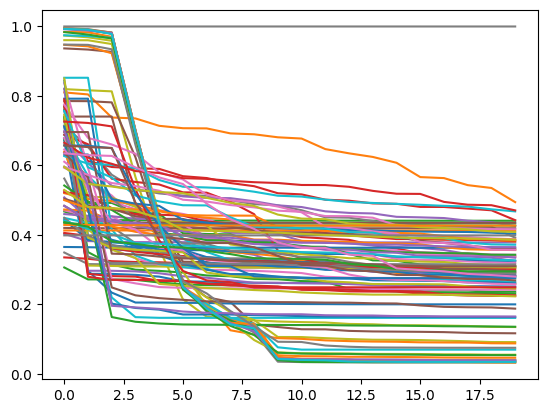

In [ ]:
for i in idx: plt.plot(sorted(trn_preds[i].data)[::-1])

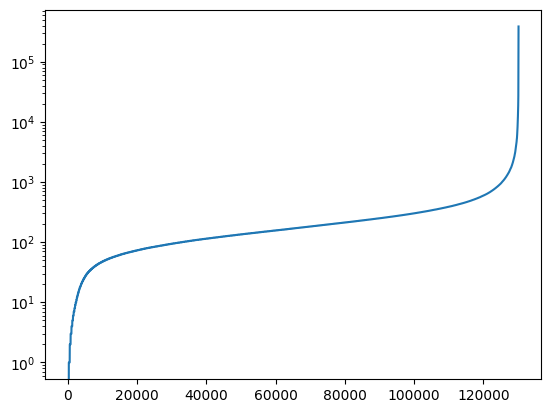

In [ ]:
data_per_lbl = trn_preds.getnnz(axis=0)
plt.plot(sorted(data_per_lbl))
plt.yscale('log')

In [ ]:
data_per_lbl.min(), data_per_lbl.max(), data_per_lbl.mean(), data_per_lbl.std()

(0, 385490, 345.5851660596001, 3395.514366426021)

### Random walk

In [ ]:
def threshold_matrix(matrix, threshold=0.5):
    mask = matrix.data < threshold
    matrix.data[mask] = 0.0
    matrix.eliminate_zeros()
    return matrix
    

In [ ]:
threshold = 0.5

In [ ]:
top_trn_preds = retain_topk(trn_preds, k=3)

top_trn_preds = threshold_matrix(top_trn_preds, threshold=0.5)

rnd_trn_preds = random_walk(top_trn_preds.T, row_head_thresh=500, col_head_thresh=500, walk_length=2)
sp.save_npz(f'{data_dir}/random_walk_train_predictions.npz', rnd_trn_preds)

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
top_tst_preds = retain_topk(tst_preds, k=3)

top_tst_preds = threshold_matrix(top_tst_preds, threshold=0.5)

rnd_tst_preds = random_walk(top_tst_preds.T, row_head_thresh=500, col_head_thresh=500, walk_length=10)
sp.save_npz(f'{data_dir}/random_walk_test_predictions.npz', rnd_tst_preds)

  0%|          | 0/128 [00:00<?, ?it/s]

### Connected components

In [ ]:
rnd_trn_lbl = sp.load_npz(f'{data_dir}/random_walk_train_predictions.npz')

(array([6.45927e+05, 1.54712e+05, 5.23740e+04, 1.85170e+04, 6.06500e+03,
        1.84400e+03, 6.27000e+02, 2.36000e+02, 9.70000e+01, 6.70000e+01]),
 array([ 1.        ,  1.89999998,  2.79999995,  3.70000005,  4.5999999 ,
         5.5       ,  6.4000001 ,  7.30000019,  8.19999981,  9.10000038,
        10.        ]),
 <BarContainer object of 10 artists>)

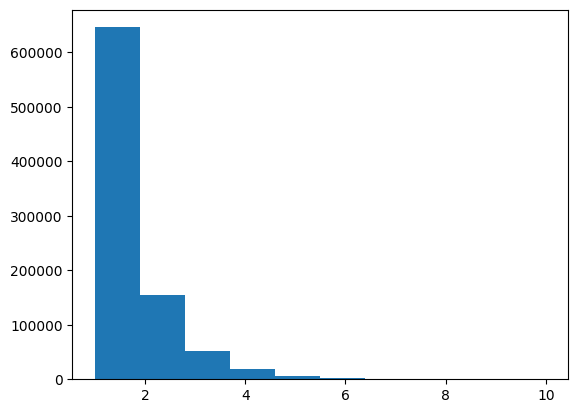

In [ ]:
plt.hist(rnd_trn_lbl.data, bins=10)

In [ ]:
n_comp, labels = connected_components(rnd_trn_lbl, directed=False, return_labels=True)

components = {}
for lbl,txt in zip(labels,linker_block.train.dset.data.lbl_info['input_text']):
    components.setdefault(lbl, []).append(txt)
    

In [ ]:
component_sz = [len(v) for v in components.values()]
min(component_sz), max(component_sz), np.mean(component_sz), np.std(component_sz)

(1, 123500, 19.69936421435059, 1519.3620287501294)

In [ ]:
n_lbl = 10
colors = list(COLORS.keys())
colors = [colors[i] for i in np.random.permutation(len(colors))]

In [ ]:
idxs = np.argsort([len(components[i]) for i in range(len(components))])[-n_lbl-1:]

In [ ]:
idxs = np.random.permutation(len(components))[:n_lbl]

In [ ]:
for i,idx in enumerate(idxs):
    if i % 2 == 0: print(colored(f'{idx+1}. {" || ".join(components[idx])}', colors[i % len(colors)]), end='\n\n')
    else: print(colored(f'{idx+1}. {" || ".join(components[idx])}', colors[i % len(colors)], attrs=["reverse", "blink"]), end='\n\n')
        

1020. Gothic Paranormal Romance || YA Thriller

2098. Crime Drama Mini-Series || TV Show Tie-In Novel || Disney Adventure Movie

385. Art and Craft Book || Art and Craft Books || Musical Instruction and Study

1588. Inspirational Historical Romance || Inspirational & Romantic Fiction || Fiction / Historical Romance

773. Christian Historical Romance Book || Christian Historical Romance || Historical Christian Romance Book

1613. Fictional Novel || Fictional Biography || Fictional Movie || Biographical Description

302. Historical Fantasy || Family Saga Fiction || War Fiction || Family Saga Novel || Historical Adventure

597. Avant-Garde Novel || Avant-Rock Album || Avant-Garde Fiction || Surrealist Fiction || Surrealist Novel

1298. Horror/Action Movie || Sci-Fi Comic Book || Action/Crime Movie || Stage Play / Movie || Play/Movie

78. Family Movie || Family Film || Biography Movie || Classic Family Movie || Television Movie



## `Zeroshot Conflation Bhavyajeet`

In [ ]:
from itertools import chain
from sugar.core import *

In [ ]:
def load_connected_components_idx(fname):
    groups = []
    with open(fname, 'r') as file:
        for line in file:
            groups.append(list(map(int, line[:-1].split(','))))
    return groups
    

In [ ]:
def load_connected_components_text(fname):
    with open(fname, 'r') as file:
        texts = [line[:-1] for line in file]
    return texts
    

In [ ]:
idx_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_ids_1.txt'
txt_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_text_1.txt'

In [ ]:
conflated_idx, conflated_text = load_connected_components_idx(idx_file), load_connected_components_text(txt_file)

In [ ]:
all_conflated_idx = list(chain(*conflated_idx))
all_unconflated_idx = list(set(range(linker_block.n_lbl)).difference(all_conflated_idx))

In [ ]:
def get_conflated_matrix(data_lbl, all_unconflated_idx, conflated_idx):
    data_lbl = data_lbl.tocsc()

    indices, indptr = [], [0]
    for idx in tqdm(all_unconflated_idx):
        x,y = data_lbl.indptr[idx],data_lbl.indptr[idx+1]
        indices.extend(data_lbl.indices[x:y])
        indptr.append(len(indices))

    for idx in tqdm(conflated_idx):
        conflated_indices = []
        for i in idx:
            x,y = data_lbl.indptr[i],data_lbl.indptr[i+1]
            conflated_indices.extend(data_lbl.indices[x:y])
        conflated_indices = list(set(conflated_indices))
        indices.extend(conflated_indices)
        indptr.append(len(indices))

    data = np.ones(len(indices))
    final_matrix = sp.csc_matrix((data, indices, indptr), shape=(data_lbl.shape[0], len(indptr)-1)).tocsr()
    return final_matrix
    

In [ ]:
trn_final_matrix = get_conflated_matrix(block.train.dset.data.data_lbl, all_unconflated_idx, conflated_idx)

  0%|          | 0/93111 [00:00<?, ?it/s]

  0%|          | 0/15587 [00:00<?, ?it/s]

In [ ]:
tst_final_matrix = get_conflated_matrix(block.test.dset.data.data_lbl, all_unconflated_idx, conflated_idx)

  0%|          | 0/93111 [00:00<?, ?it/s]

  0%|          | 0/15587 [00:00<?, ?it/s]

In [ ]:
final_text = [linker_block.train.dset.data.data_info['input_text'][i] for i in all_unconflated_idx] + conflated_text

In [ ]:
save_dir = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations'

In [ ]:
sp.save_npz(f'{save_dir}/category_gpt_conflated_trn_X_Y.npz', trn_final_matrix)
sp.save_npz(f'{save_dir}/category_gpt_conflated_tst_X_Y.npz', tst_final_matrix)
save_raw_file(f'{save_dir}/raw_data/category_gpt_conflated.raw.csv', list(range(len(final_text))), final_text)

In [ ]:
def load_conflated_metadata(block, idx_file, txt_file, meta_name, remove_ids=[]):
    conflated_idx, conflated_text = load_connected_components_idx(idx_file), load_connected_components_text(txt_file)
    
    all_conflated_idx = list(chain(*conflated_idx))
    all_unconflated_idx = list(set(range(block.train.dset.meta[meta_name].n_meta)).difference(all_conflated_idx))

    all_conflated_idx = list(set(all_conflated_idx).difference(remove_ids))
    all_unconflated_idx = list(set(all_unconflated_idx).difference(remove_ids))

    trn_final_matrix = get_conflated_matrix(block.train.dset.meta[meta_name].data_meta, all_unconflated_idx, conflated_idx)
    tst_final_matrix = get_conflated_matrix(block.test.dset.meta[meta_name].data_meta, all_unconflated_idx, conflated_idx)
    lbl_final_matrix = get_conflated_matrix(block.train.dset.meta[meta_name].lbl_meta, all_unconflated_idx, conflated_idx)

    final_text = [block.train.dset.meta[meta_name].meta_info['input_text'][i] for i in all_unconflated_idx] + [o.split(',')[0] for o in conflated_text]

    return trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text
    

In [ ]:
def save_conflated_metadata(save_dir, trn_matrix, tst_matrix, lbl_matrix, meta_text, suffix=''):
    if len(suffix): suffix = f'-{suffix}'
    sp.save_npz(f'{save_dir}/category_gpt_conflated{suffix}_trn_X_Y.npz', trn_matrix)
    sp.save_npz(f'{save_dir}/category_gpt_conflated{suffix}_tst_X_Y.npz', tst_matrix)
    sp.save_npz(f'{save_dir}/category_gpt_conflated{suffix}_lbl_X_Y.npz', lbl_matrix)
    save_raw_file(f'{save_dir}/raw_data/category_gpt_conflated{suffix}.raw.csv', list(range(len(meta_text))), meta_text)
    

In [ ]:
def load_and_save_conflated_metadata(block, idx_file, txt_file, meta_name, save_dir, suffix='', remove_ids=[]):
    trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text = load_conflated_metadata(block, idx_file, txt_file, meta_name, remove_ids)
    save_conflated_metadata(save_dir, trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text, suffix=suffix)
    return trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text
    

In [ ]:
idx_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_ids_1.txt'
txt_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_text_1.txt'

save_dir = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations'

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text = load_and_save_conflated_metadata(block, idx_file, txt_file, 'cat_meta', 
                                                                                                    save_dir, suffix='1', remove_ids=[36])

  0%|          | 0/93110 [00:00<?, ?it/s]

  0%|          | 0/15587 [00:00<?, ?it/s]

  0%|          | 0/93110 [00:00<?, ?it/s]

  0%|          | 0/15587 [00:00<?, ?it/s]

  0%|          | 0/93110 [00:00<?, ?it/s]

  0%|          | 0/15587 [00:00<?, ?it/s]

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix

(<2248619x108697 sparse matrix of type '<class 'numpy.float64'>'
 	with 2179546 stored elements in Compressed Sparse Row format>,
 <970237x108697 sparse matrix of type '<class 'numpy.float64'>'
 	with 930536 stored elements in Compressed Sparse Row format>,
 <1305265x108697 sparse matrix of type '<class 'numpy.float64'>'
 	with 1178953 stored elements in Compressed Sparse Row format>)

In [ ]:
idx_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_ids_2.txt'
txt_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_text_2.txt'

save_dir = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations'

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text = load_and_save_conflated_metadata(block, idx_file, txt_file, 'cat_meta', 
                                                                                                    save_dir, suffix='2', remove_ids=[36])

  0%|          | 0/79803 [00:00<?, ?it/s]

  0%|          | 0/17858 [00:00<?, ?it/s]

  0%|          | 0/79803 [00:00<?, ?it/s]

  0%|          | 0/17858 [00:00<?, ?it/s]

  0%|          | 0/79803 [00:00<?, ?it/s]

  0%|          | 0/17858 [00:00<?, ?it/s]

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix

(<2248619x97661 sparse matrix of type '<class 'numpy.float64'>'
 	with 2179547 stored elements in Compressed Sparse Row format>,
 <970237x97661 sparse matrix of type '<class 'numpy.float64'>'
 	with 930537 stored elements in Compressed Sparse Row format>,
 <1305265x97661 sparse matrix of type '<class 'numpy.float64'>'
 	with 1178954 stored elements in Compressed Sparse Row format>)

In [ ]:
idx_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_ids_3.txt'
txt_file = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/connected_components_text_3.txt'

save_dir = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations'

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix, final_text = load_and_save_conflated_metadata(block, idx_file, txt_file, 'cat_meta', 
                                                                                                    save_dir, suffix='3', remove_ids=[36])

  0%|          | 0/48743 [00:00<?, ?it/s]

  0%|          | 0/26783 [00:00<?, ?it/s]

  0%|          | 0/48743 [00:00<?, ?it/s]

  0%|          | 0/26783 [00:00<?, ?it/s]

  0%|          | 0/48743 [00:00<?, ?it/s]

  0%|          | 0/26783 [00:00<?, ?it/s]

In [ ]:
trn_final_matrix, tst_final_matrix, lbl_final_matrix

(<2248619x75526 sparse matrix of type '<class 'numpy.float64'>'
 	with 2179563 stored elements in Compressed Sparse Row format>,
 <970237x75526 sparse matrix of type '<class 'numpy.float64'>'
 	with 930546 stored elements in Compressed Sparse Row format>,
 <1305265x75526 sparse matrix of type '<class 'numpy.float64'>'
 	with 1178969 stored elements in Compressed Sparse Row format>)

### Visualize conflated categories

In [ ]:
pkl_dir = '/scratch/scai/phd/aiz218323/datasets/processed/'
pkl_file = f'{pkl_dir}/mogicX/amazontitles_data-gpt-category-conflated-3_distilbert-base-uncased_sxc.joblib'

config_file = '../configs/16_ngame-linker-for-amazontitles-003_gpt-category-conflated-3.json'
config_key = 'data_category'

block = build_block(pkl_file, config_file, use_sxc=True, config_key=config_key)
linker_block = block.linker_dset('cat_meta', remove_empty=False)

In [ ]:
disp = TextDataset(XCDataset._initialize(linker_block.test.dset))

In [ ]:
disp.show(k=100)

data_input_text : PVC 1/2" Mist Coupling with .012 Brass Mist Nozzle (Bag of 25)
lbl2data_input_text : ['Plumbing & HVAC']

data_input_text : The Limits of Morality (Oxford Ethics)
lbl2data_input_text : ['Philosophy Book']

data_input_text : The Everyday Torah: Weekly Reflections and Inspirations
lbl2data_input_text : ['Religious Book']

data_input_text : Clear Protector Case for Samsung Galaxy S II i777 (AT&T)
lbl2data_input_text : ['Mobile Phone Toy']

data_input_text : 6" BOB DS (Carefree Collection) - Synthetic Ponytail in JET BLACK
lbl2data_input_text : ['Hair Extensions']

data_input_text : Global Wesleyan Dictionary of Theology
lbl2data_input_text : ['Theology Book']

data_input_text : Heartbeat
lbl2data_input_text : ['Album']

data_input_text : Maybelline Volume XL Seduction Lip Plumper - Xtremely Sheer
lbl2data_input_text : ['Lip Plumper']

data_input_text : Jorge from Argentina: The Story of Pope Francis for Children
lbl2data_input_text : ["Children's Biography"]

data_input_

In [ ]:
save_dir = '/home/scai/phd/aiz218323/scratch/datasets/benchmarks/LF-AmazonTitles-1.3M_gpt-conflations/examples'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
idxs = np.random.permutation(linker_block.test.dset.n_data)[:1000]
disp.dump_txt(f'{save_dir}/gpt-category-conflated-3.txt', idxs=idxs)